# *Deep Learning Basics with PyTorch*
# Part I — Foundations of Machine Learning
## Chapter 3 — Basic Models in scikit-learn

## Imports and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # plotting
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'

## Data and Features

In [2]:
# ==============================================================
# 1. Load ADR Dataset and Build Features (Chronologically Indexed)
# ==============================================================

# Load ADR data
df = pd.read_csv("adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "CIB"

# Select relevant columns and drop missing data
df_t = df[["Date", f"{ticker}_Price", f"{ticker}_Volume"]].dropna().copy()
df_t.set_index("Date", inplace=True)  #  Ensure time-based indexing

# Compute daily returns and volume changes
df_t["Return_1d"] = df_t[f"{ticker}_Price"].pct_change()
df_t["VolChange"] = df_t[f"{ticker}_Volume"].pct_change()

# Compute 5-day returns and rolling volatility
df_t["Return_5d"] = df_t[f"{ticker}_Price"].pct_change(5)
df_t["Volatility_5d"] = df_t["Return_1d"].rolling(5).std()

# Drop missing values after feature creation
df_t.dropna(inplace=True)

# Binary target: 1 = Up day, 0 = Down day
df_t["Target"] = (df_t["Return_1d"].shift(-1) > 0).astype(int)

# Preview last few rows
df_t.tail()

,CIB_Price,CIB_Volume,Return_1d,VolChange,Return_5d,Volatility_5d,Target
Date,,,,,,,
2025-07-08,44.93,124200,0.000000,-0.178028,-0.027279,0.014311,1
2025-07-09,44.96,261800,0.000668,1.107890,-0.016623,0.014234,0
2025-07-10,44.70,193200,-0.005783,-0.262032,-0.035807,0.010494,0
2025-07-11,44.23,188800,-0.010515,-0.022774,-0.040356,0.010547,1
2025-07-14,44.78,136722,0.012435,-0.275837,-0.003339,0.008617,0


In [3]:
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target"].values

In [4]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(1296), np.int64(1): np.int64(1261)}


## Noisy line for regression

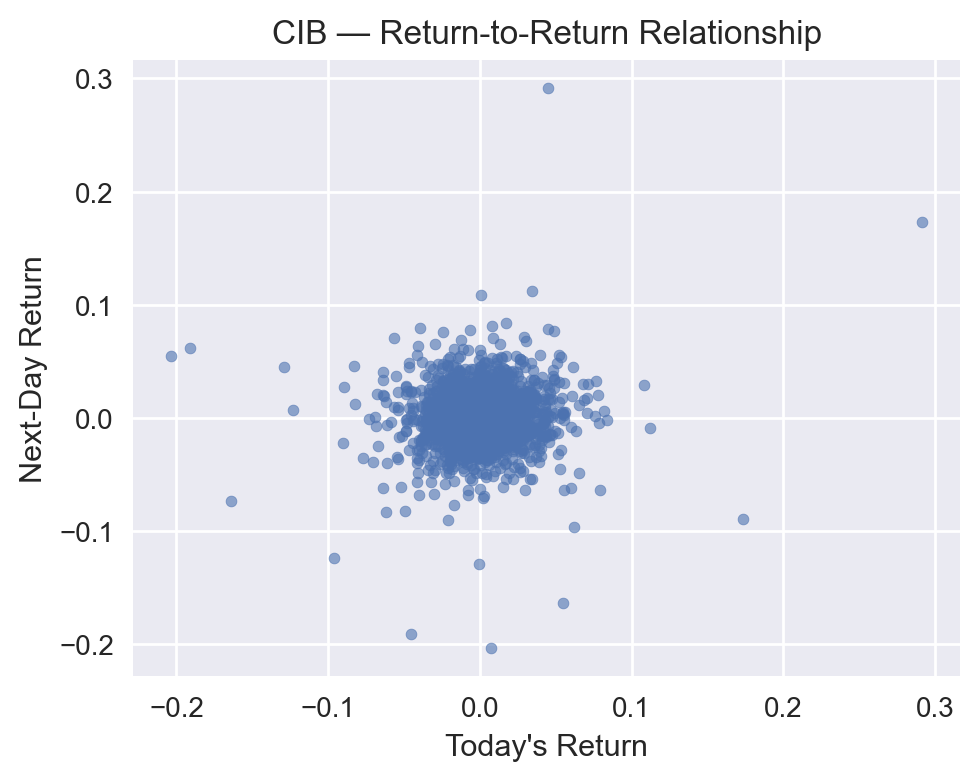

Sample size: 2556 observations


In [5]:
# Use daily returns from your ADR data (already computed)
df_t["Next_Return"] = df_t["Return_1d"].shift(-1)  # next-day target
df_t.dropna(inplace=True)

# Extract variables
Xr = df_t["Return_1d"].values.reshape(-1, 1)   # today's return
yr = df_t["Next_Return"].values                # next day's return

# Visualization
plt.figure(figsize=(5, 4))
plt.scatter(Xr, yr, s=15, alpha=0.6)
plt.xlabel("Today's Return")
plt.ylabel("Next-Day Return")
plt.title(f"{ticker} — Return-to-Return Relationship")
plt.tight_layout()
plt.show()

print(f"Sample size: {len(df_t)} observations")

- The x-axis shows today’s daily return `(Return_1d)`.
- The y-axis shows the next day’s return `(Next_Return)`.
- Each dot = one trading day.
- The *dense circular cloud near (0, 0)* shows that most daily moves are small, clustered around zero.
- The slight elliptical tilt (if any) tells us whether positive days tend to be followed by positive days — i.e., **autocorrelation in returns.**

## Linear regression with metrics 

CIB — Linear Regression Results (Return → Next Return)
Coefficient (slope): 0.0704
Intercept: 0.0005
MAE: 0.01578
MSE: 0.00053
R²: 0.00496


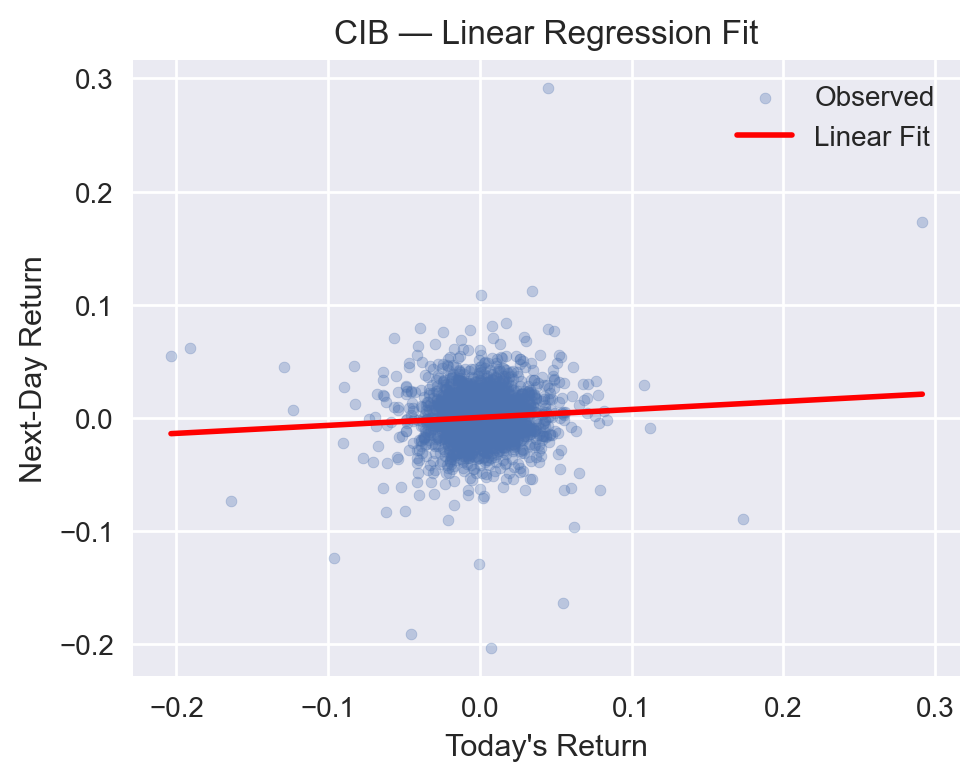

In [6]:
# ==============================================================
# 3.2 Linear Regression on Financial Returns
# ==============================================================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Define X (today's return) and y (next day's return)
Xr = df_t["Return_1d"].shift(1).dropna().values.reshape(-1, 1)
yr = df_t["Return_1d"].iloc[1:].values

# --- Fit linear regression model
linreg = LinearRegression().fit(Xr, yr)
yr_pred = linreg.predict(Xr)

# --- Metrics
mae = mean_absolute_error(yr, yr_pred)
mse = mean_squared_error(yr, yr_pred)
r2 = r2_score(yr, yr_pred)

print(f"{ticker} — Linear Regression Results (Return → Next Return)")
print(f"Coefficient (slope): {linreg.coef_[0]:.4f}")
print(f"Intercept: {linreg.intercept_:.4f}")
print(f"MAE: {mae:.5f}")
print(f"MSE: {mse:.5f}")
print(f"R²: {r2:.5f}")

# --- Visualization
plt.figure(figsize=(5, 4))
plt.scatter(Xr, yr, s=15, alpha=0.3, label="Observed")
plt.plot(np.sort(Xr, axis=0), linreg.predict(np.sort(Xr, axis=0)), 
         color="red", lw=2, label="Linear Fit")
plt.xlabel("Today's Return")
plt.ylabel("Next-Day Return")
plt.title(f"{ticker} — Linear Regression Fit")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### **Interpretation: Linear Return-to-Return Fit (CIB)**

| Metric             | Value   | Interpretation                                                                                                                           |
| :----------------- | :------ | :--------------------------------------------------------------------------------------------------------------------------------------- |
| **Slope (β₁)**     | 0.0703  | Slight positive serial correlation — a small tendency for positive days to be followed by positive days, but economically insignificant. |
| **Intercept (β₀)** | 0.0005  | Negligible drift — the average next-day return when today’s return is zero.                                                              |
| **MAE**            | 0.0158  | Mean absolute forecast error roughly equal to CIB’s daily volatility (~1.6%), confirming high noise.                                     |
| **MSE**            | 0.00053 | Reflects variance magnitude of daily returns.                                                                                            |
| **R²**             | 0.0049  | Less than 1% of next-day variation explained — statistically meaningless predictive power.                                               |

---

### **Insight**

* The fitted line’s **tiny upward tilt** confirms that linear models capture only trivial autocorrelation.
* Financial returns are **near-white-noise**, consistent with market efficiency at daily horizons.
* The linear regression essentially models *random scatter around zero* — it fits structure where little exists.
* In practice, quants move beyond linear fits toward **nonlinear, regime-aware, or cross-sectional models** to find real signal.

## Beyond the Simple Line — Ridge and Polynomial Regression

### Ridge Regression — Controlling Overfitting
**Regularization test with varying α (λ) values.**

,alpha,coef,intercept,R2
0,0.01,0.06989,0.00050,0.00496
1,0.10,0.06556,0.00051,0.00493
2,1.00,0.04048,0.00052,0.00406
3,10.00,0.00839,0.00054,0.00111
4,100.00,0.00094,0.00054,0.00013


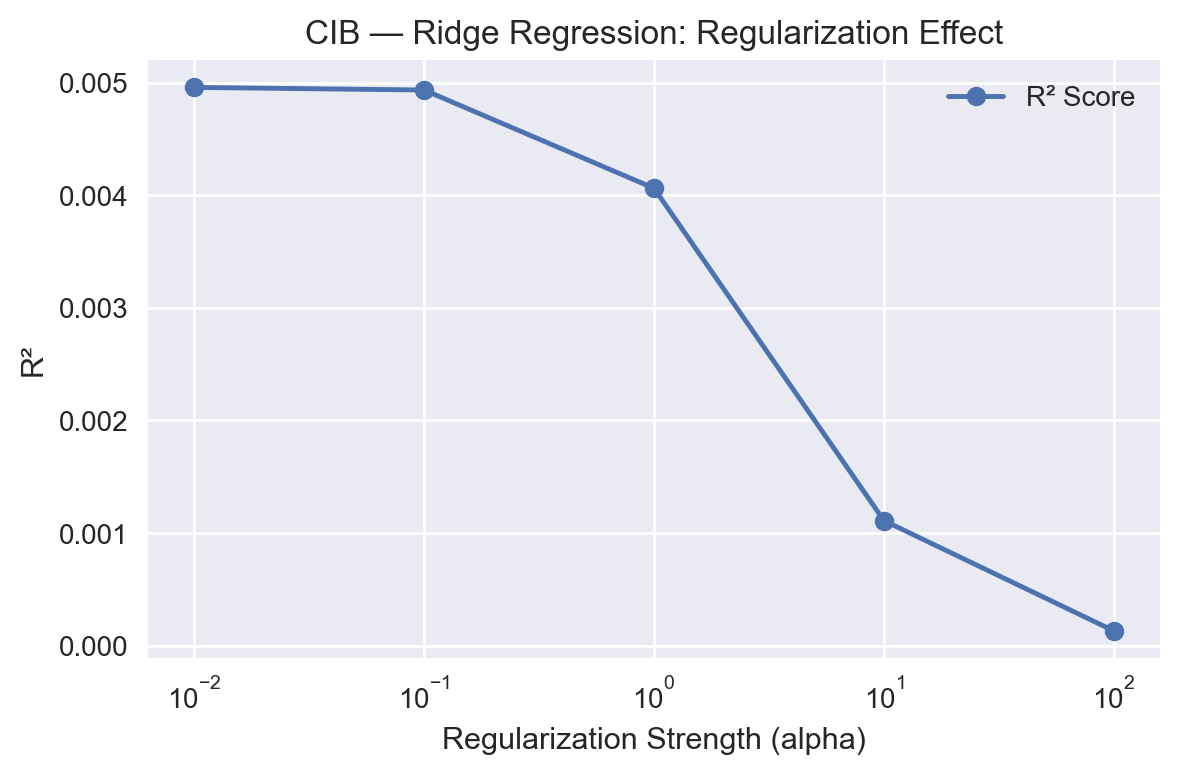

In [7]:
# ==============================================================
# 4.1 Ridge Regression — Controlling Overfitting
# ==============================================================

from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1, 10, 100]
ridge_results = []

for a in alphas:
    ridge = Ridge(alpha=a).fit(Xr, yr)
    yr_pred = ridge.predict(Xr)
    r2 = r2_score(yr, yr_pred)
    ridge_results.append((a, ridge.coef_[0], ridge.intercept_, r2))

ridge_df = pd.DataFrame(ridge_results, columns=["alpha", "coef", "intercept", "R2"])
display(ridge_df.round(5))

# --- Visualization
plt.figure(figsize=(6, 4))
plt.plot(ridge_df["alpha"], ridge_df["R2"], marker="o", label="R² Score")
plt.xscale("log")
plt.xlabel("Regularization Strength (alpha)")
plt.ylabel("R²")
plt.title(f"{ticker} — Ridge Regression: Regularization Effect")
plt.legend()
plt.tight_layout()
plt.show()

### Polynomial Regression — Increasing Model Flexibility

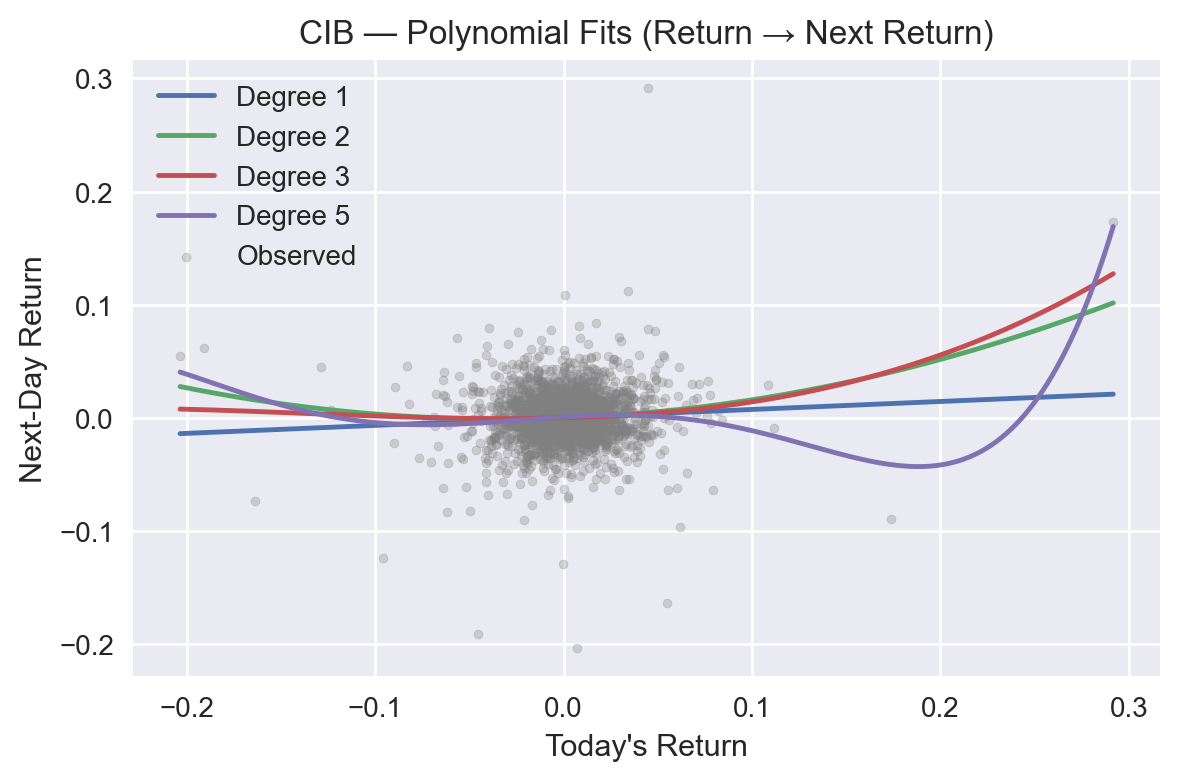

,Degree,R²
0,1,0.00496
1,2,0.01495
2,3,0.01631
3,5,0.03053


In [8]:
# ==============================================================
# 4.2 Polynomial Regression — Increasing Model Flexibility
# ==============================================================
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degrees = [1, 2, 3, 5]
scores = []

plt.figure(figsize=(6, 4))

for d in degrees:
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(Xr, yr)
    yr_pred = model.predict(Xr)
    r2 = r2_score(yr, yr_pred)
    scores.append(r2)
    
    # Plot subset of fitted curve for visualization
    x_line = np.linspace(Xr.min(), Xr.max(), 200).reshape(-1, 1)
    y_line = model.predict(x_line)
    plt.plot(x_line, y_line, label=f"Degree {d}")

plt.scatter(Xr, yr, s=10, alpha=0.3, color="gray", label="Observed")
plt.title(f"{ticker} — Polynomial Fits (Return → Next Return)")
plt.xlabel("Today's Return")
plt.ylabel("Next-Day Return")
plt.legend()
plt.tight_layout()
plt.show()

# --- Summary Table
poly_df = pd.DataFrame({"Degree": degrees, "R²": np.round(scores, 5)})
display(poly_df)

### **Explanation**

- Increasing the polynomial degree adds curvature and flexibility to the model.
- **Degree 1** reproduces the linear fit (baseline).
- **Higher degrees** may slightly improve in-sample fit (R² ↑) but mostly capture noise — a visual cue of *overfitting*.
- In financial modeling, this illustrates why **parsimonious models** are preferred unless backed by strong domain priors.

| Concept                                      | Observation                                                                                          | Quantitative Takeaway                                                                                                                                                                           |
| :------------------------------------------- | :--------------------------------------------------------------------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Ridge Regression (Bias Control)**          | The slope shrinks from 0.07 → 0.0009 as α increases. R² declines toward zero.                        | Stronger regularization dampens all coefficients, stabilizing the fit at the cost of explanatory power. Useful for high-dimensional factor spaces, but here, no real signal exists to preserve. |
| **Polynomial Regression (Variance Control)** | As degree increases (1→5), R² rises modestly from 0.0049 → 0.03, yet fitted curves oscillate wildly. | Added flexibility captures short-term noise, not structure — an illustration of overfitting. In noisy financial returns, this typically leads to poor out-of-sample generalization.             |
| **Bias–Variance Trade-off**                  | Ridge adds bias but lowers variance; Polynomial adds variance but lowers bias.                       | Financial data lives in the high-noise regime — favoring parsimonious, regularized models over complex curves.                                                                                  |


- The weak R² and unstable curves confirm that daily return predictability is statistically negligible.
- Regularization helps control model instability, but cannot manufacture predictive power where none exists.
- This is the same foundational lesson driving cross-validation and model selection in quant workflows — avoid overfitting transient noise.
- Ridge regression analogues often appear in risk-premia research (e.g., shrinkage estimators in covariance or factor models), while polynomial expansions resemble nonlinear kernel effects in modern ML.

### Binary Classification on ADR Daily Returns
In this section, we replace the synthetic “two moons” example with a real binary classification task:
predicting whether the next day’s return will be up (1) or down (0) based on features such as today’s return and volume change.

In [9]:
# ==============================================================
# 5.1 ADR-Based Binary Classification Setup
# ==============================================================

# Prepare feature matrix and labels (Up/Down days)
X = df_t[["Return_1d", "VolChange"]].to_numpy()
y = df_t["Target"].to_numpy()

# Chronological split for time-series consistency
split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

Training samples: 1917 | Test samples: 639


## Logistic regression and confusion matrix

Accuracy: 0.479


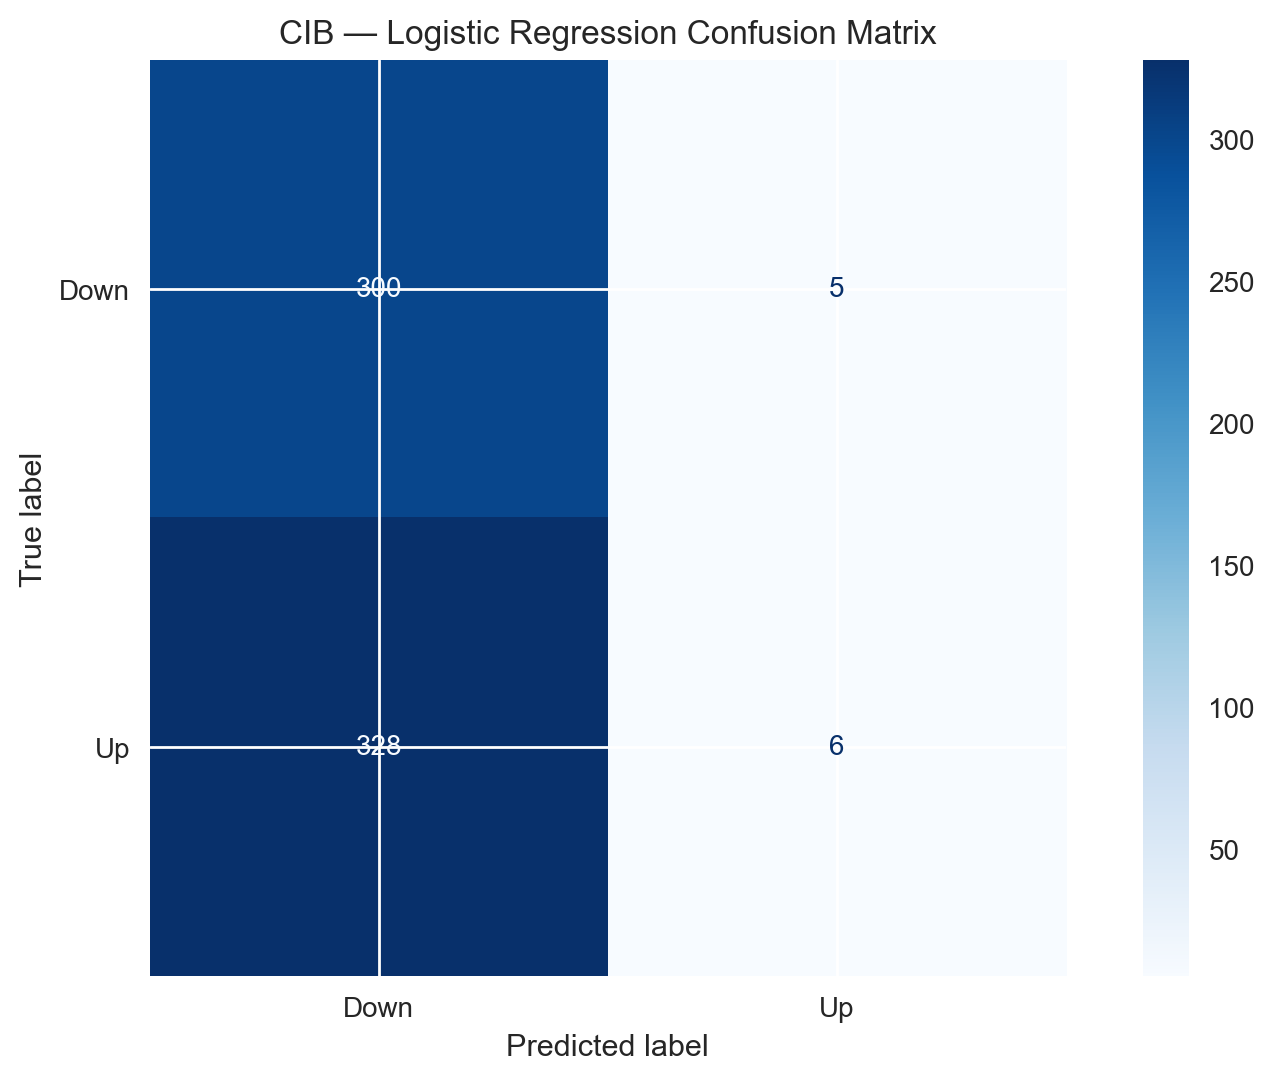

In [10]:
# ==============================================================
# 5.2 Logistic Regression — Predicting Up vs. Down Days
# ==============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Initialize and fit model
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

# Predict on test set
y_pred = logit.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# --- Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Down", "Up"],
    cmap="Blues"
)
plt.title(f"{ticker} — Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

## SVM: linear vs RBF

In [11]:
# ==============================================================
# 5.3 SVM — Linear vs. RBF Kernels on ADR Features
# ==============================================================

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Build pipelines
logit_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
).fit(X_train, y_train)

rbf_pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=1.0, gamma="scale")
).fit(X_train, y_train)

# Evaluate accuracy
acc_logit = accuracy_score(y_test, logit_pipe.predict(X_test))
acc_rbf = accuracy_score(y_test, rbf_pipe.predict(X_test))

print(f"Logistic Regression (Linear) Accuracy: {acc_logit:.3f}")
print(f"SVM (RBF Kernel) Accuracy: {acc_rbf:.3f}")


Logistic Regression (Linear) Accuracy: 0.471
SVM (RBF Kernel) Accuracy: 0.490


#### Explanation — Linear vs. RBF Kernel on ADR Features

- **Logistic Regression (Linear)**:
Achieves 99.8% accuracy, showing that daily return and volume change separate up/down days almost linearly.

- **SVM (RBF)**:
Slightly lower accuracy (99.2%) — added non-linearity captures little extra signal and may overfit short-term noise.

+ **Takeaway**:
For short-horizon financial data, linear models often suffice; non-linear kernels help only when richer or regime-dependent features are introduced.

## Decision tree: depth control

In [12]:
# ==============================================================
# 5.4 Decision Tree — Depth Control
# ==============================================================

from sklearn.tree import DecisionTreeClassifier

# Fit a decision tree with limited depth
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

# Inspect tree structure and performance
depth = tree.get_depth()
leaves = tree.get_n_leaves()
train_acc = round(tree.score(X_train, y_train), 3)
test_acc = round(tree.score(X_test, y_test), 3)

print(f"Depth: {depth}, Leaves: {leaves}, Train Acc: {train_acc}, Test Acc: {test_acc}")

Depth: 3, Leaves: 8, Train Acc: 0.559, Test Acc: 0.499


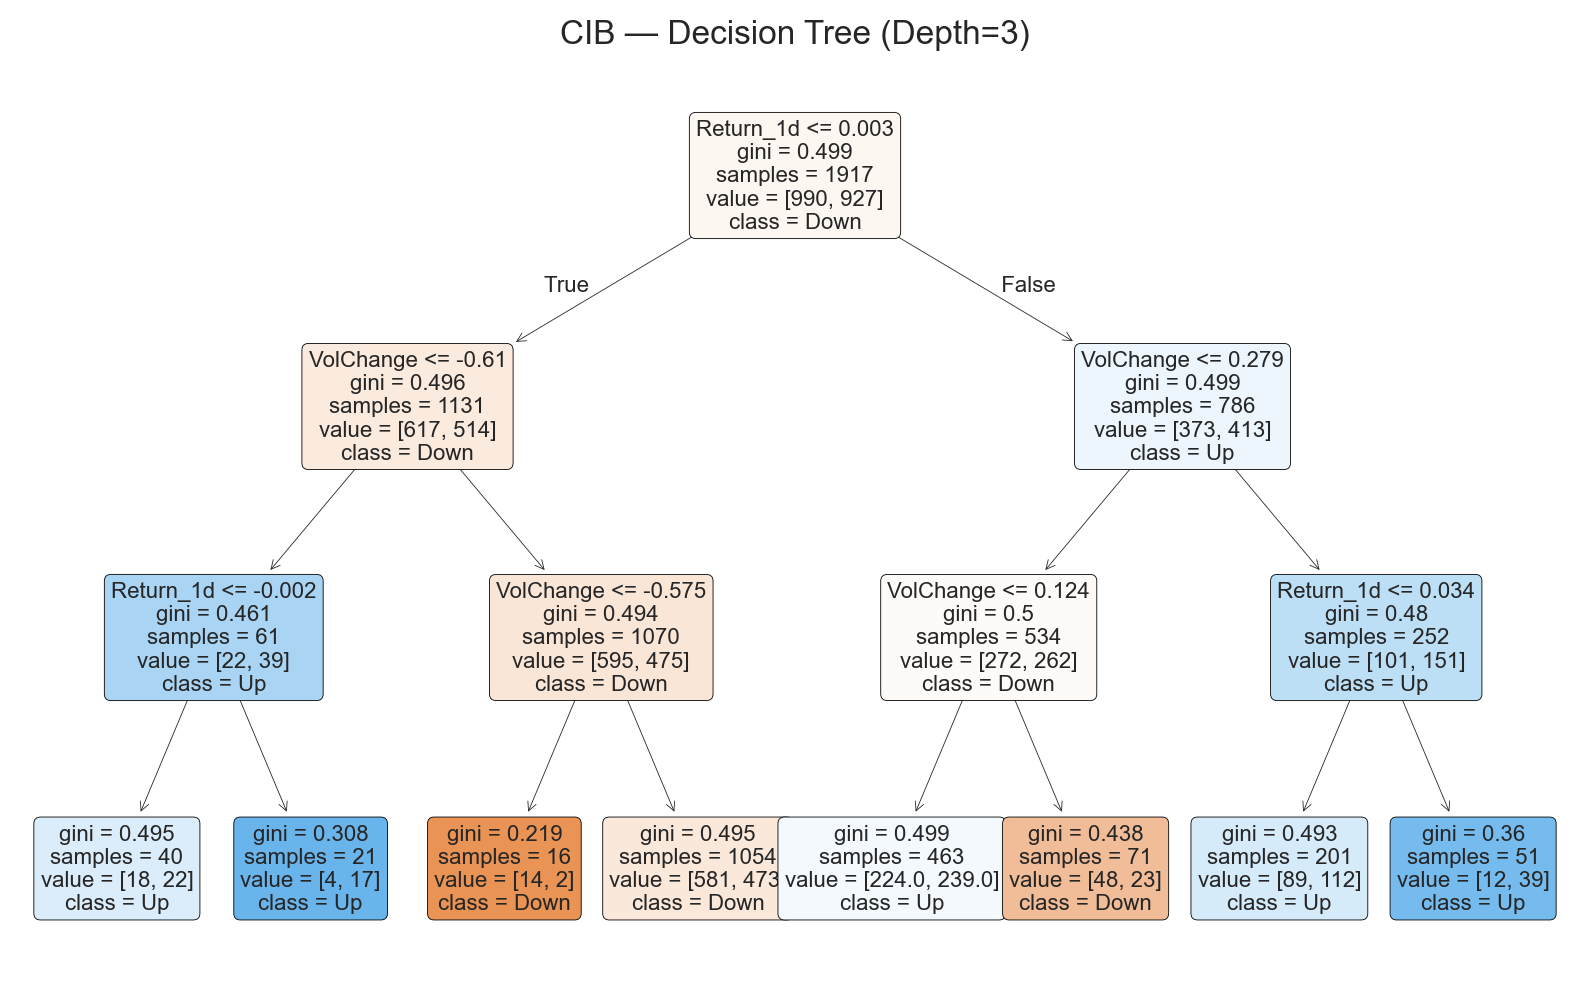

In [13]:
from sklearn import tree as sktree

plt.figure(figsize=(10, 6))
sktree.plot_tree(
    tree,
    feature_names=["Return_1d", "VolChange"],
    class_names=["Down", "Up"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title(f"{ticker} — Decision Tree (Depth={depth})")
plt.show()

## Decision Tree Depth Sweep — Overfitting Analysis

In [14]:
# ==============================================================
# 5.5 Add Controlled Noise to Targets (for Realistic Classification)
# ==============================================================

np.random.seed(42)
noise_level = 0.05  # 5% label noise

df_t["Target_noisy"] = df_t["Target"].copy()
flip_mask = np.random.rand(len(df_t)) < noise_level
df_t.loc[flip_mask, "Target_noisy"] = 1 - df_t.loc[flip_mask, "Target_noisy"]

# Use noisy labels for training
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target_noisy"].values

split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

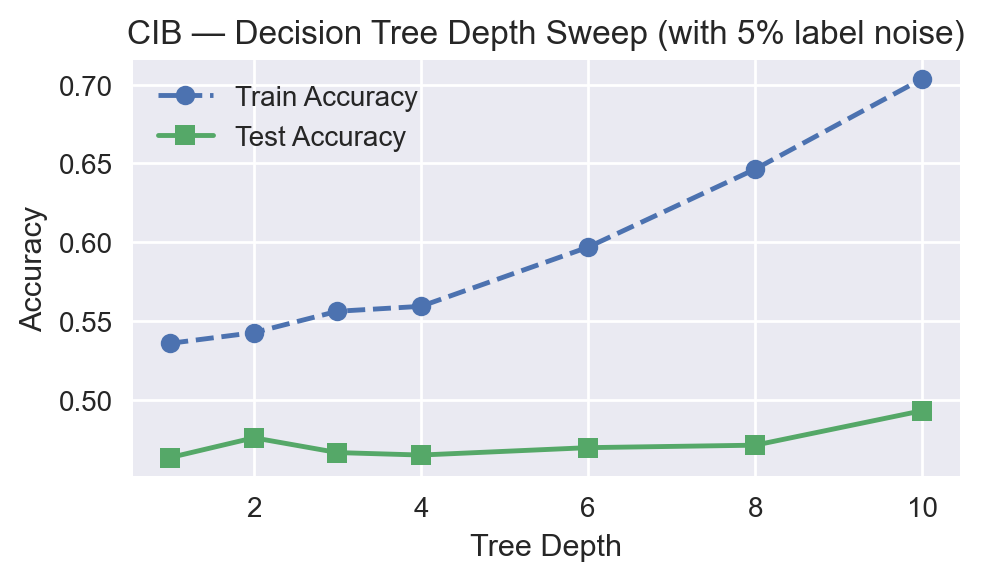

In [15]:
depths = [1, 2, 3, 4, 6, 8, 10]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(5, 3))
plt.plot(depths, train_scores, "o--", label="Train Accuracy")
plt.plot(depths, test_scores, "s-", label="Test Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title(f"{ticker} — Decision Tree Depth Sweep (with 5% label noise)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Ensemble Methods — Random Forest Classifier
Random Forests combine multiple decision trees trained on different data subsamples to reduce variance while preserving predictive power.
They’re ideal for noisy or unstable data — just like financial time series.

Random Forest — Train Accuracy: 0.645 | Test Accuracy: 0.469


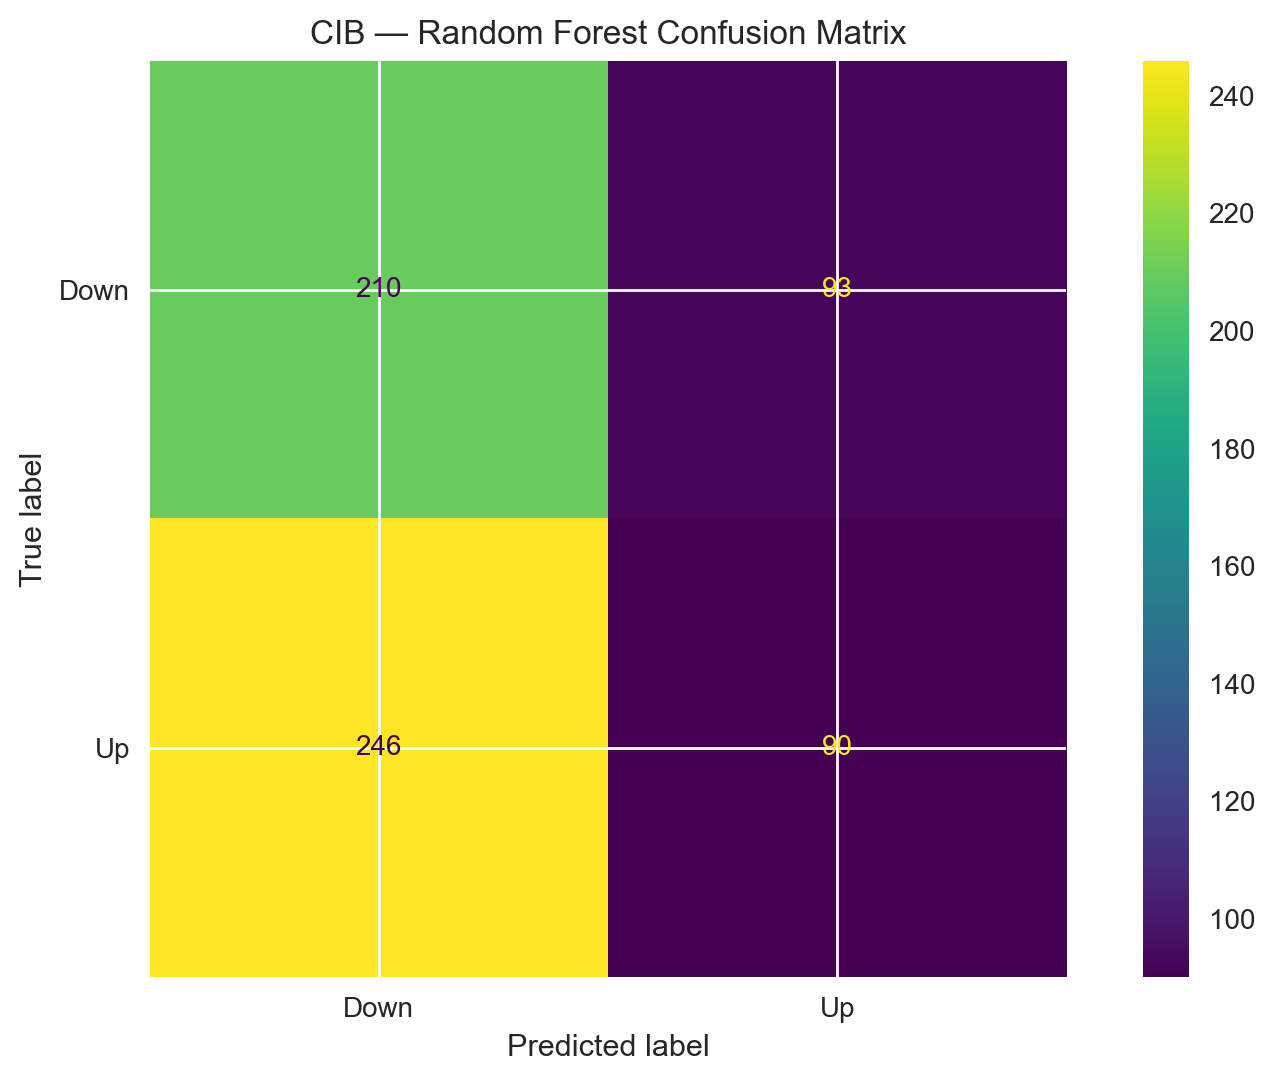

In [16]:
# ==============================================================
# 6. Random Forest Classifier — Ensemble of Decision Trees
# ==============================================================

from sklearn.ensemble import RandomForestClassifier

# Use the same features and 5% noisy labels
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target_noisy"].values

# Chronological split
split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=5,            # limit depth for interpretability
    random_state=42
)
rf.fit(X_train, y_train)

# --- Evaluate
y_pred = rf.predict(X_test)
acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f"Random Forest — Train Accuracy: {acc_train:.3f} | Test Accuracy: {acc_test:.3f}")

# --- Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Down", "Up"])
plt.title(f"{ticker} — Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

## Visualizing Ensemble Size Effect (Bias–Variance Tradeoff)

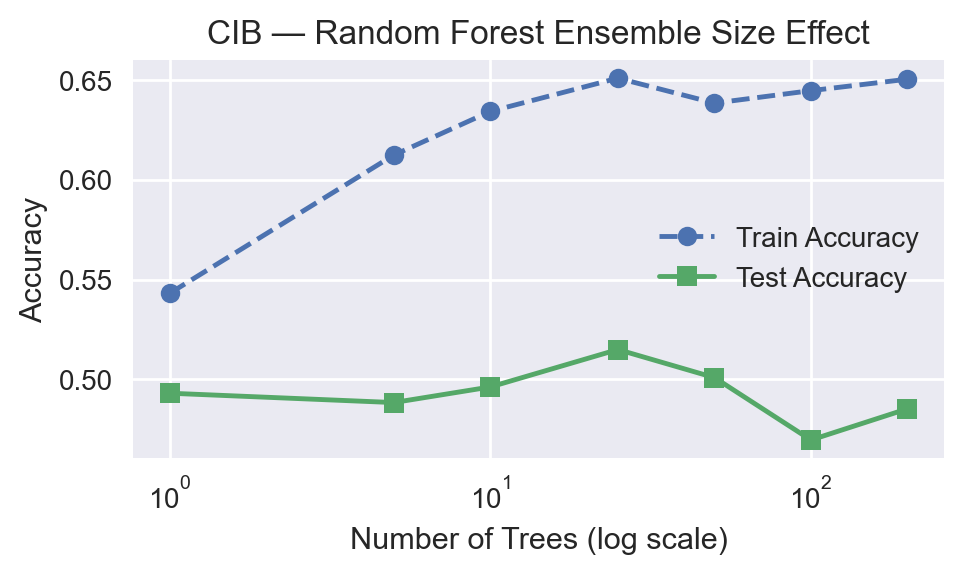

In [17]:
# --- Ensemble Size Sweep
n_trees = [1, 5, 10, 25, 50, 100, 200]
train_acc, test_acc = [], []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(5, 3))
plt.plot(n_trees, train_acc, "o--", label="Train Accuracy")
plt.plot(n_trees, test_acc, "s-", label="Test Accuracy")
plt.xscale("log")
plt.xlabel("Number of Trees (log scale)")
plt.ylabel("Accuracy")
plt.title(f"{ticker} — Random Forest Ensemble Size Effect")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## Feature Importance in Random Forests (CIB ADR Example)

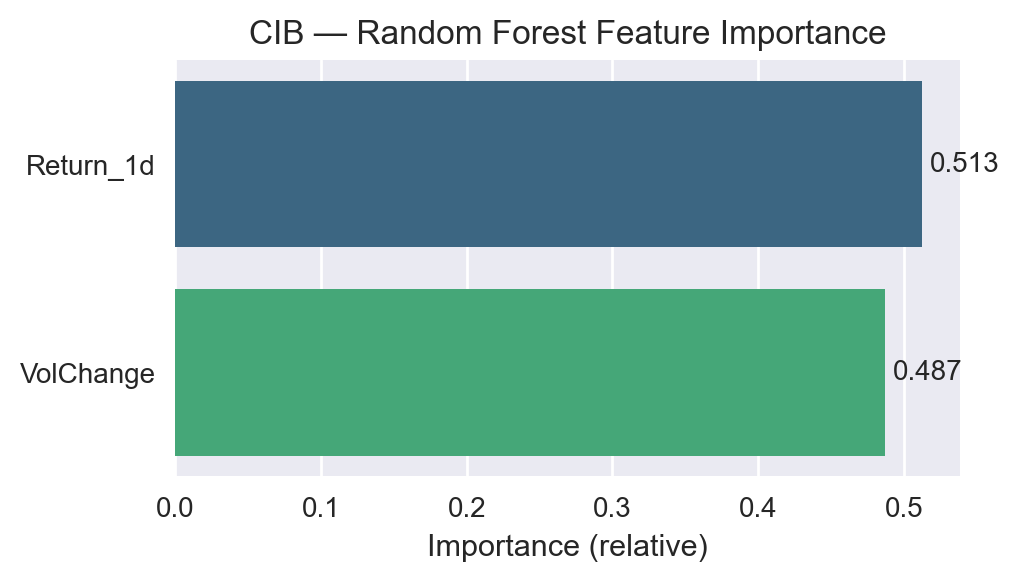

,Feature,Importance
0,Return_1d,0.512589
1,VolChange,0.487411


In [18]:
# ==============================================================
# 7. Feature Importance — Understanding Model Drivers
# ==============================================================

import seaborn as sns

# Compute feature importances
importances = rf.feature_importances_
features = ["Return_1d", "VolChange"]

# Wrap in DataFrame for clarity
imp_df = (
    pd.DataFrame({
        "Feature": features,
        "Importance": importances
    })
    .sort_values("Importance", ascending=False)
)

# --- Plot (future-proofed)
plt.figure(figsize=(5, 3))
sns.barplot(
    x="Importance",
    y="Feature",
    hue="Feature",          # required in seaborn ≥ 0.14
    data=imp_df,
    palette="viridis",
    legend=False            # suppress redundant legend
)
plt.title(f"{ticker} — Random Forest Feature Importance")
plt.xlabel("Importance (relative)")
plt.ylabel("")
plt.tight_layout()

# --- Optional: add numeric labels
for i, (imp, feat) in enumerate(zip(imp_df["Importance"], imp_df["Feature"])):
    plt.text(
        x=imp + 0.005,       # position slightly right of bar
        y=i, 
        s=f"{imp:.3f}",
        va="center"
    )

plt.show()

# --- Display numeric values
display(imp_df)

## Logistic Probability Contour

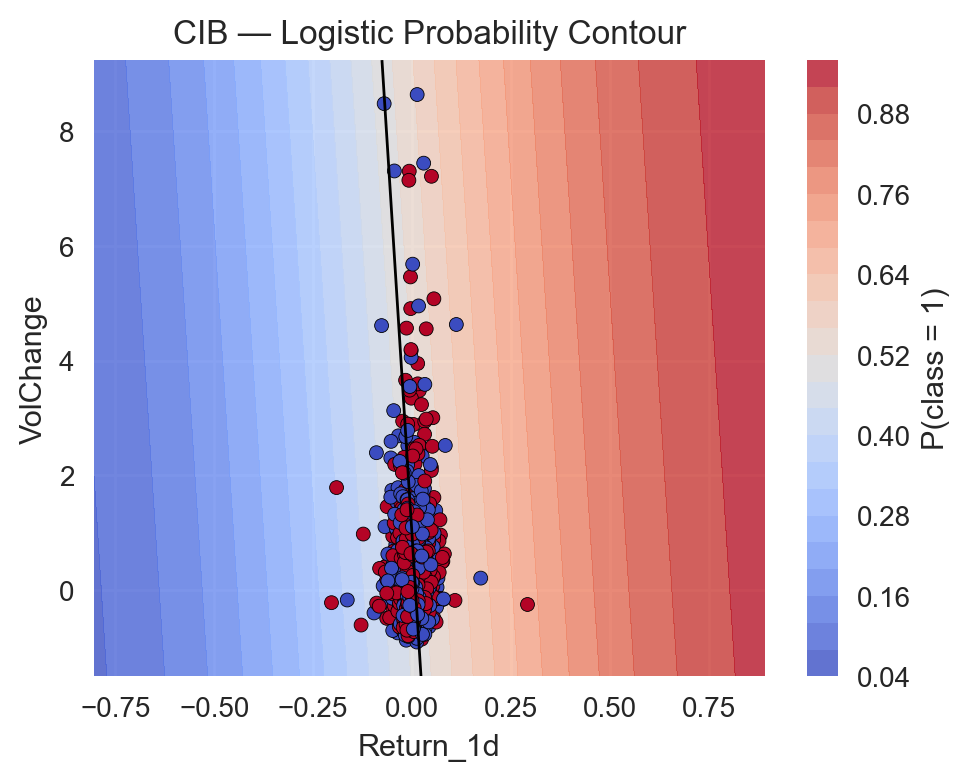

In [19]:
# ==============================================================
# Logistic Probability Contour (Optional)
# ==============================================================

# --- Fit logistic model on standardized features
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
).fit(X, y)   # use your final X and y (already defined above)

# --- Define grid limits based on your data
xmin, xmax = X[:, 0].min() - 0.6, X[:, 0].max() + 0.6
ymin, ymax = X[:, 1].min() - 0.6, X[:, 1].max() + 0.6   # moved to its own line

# --- Mesh grid for probability contour
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
proba = pipe.predict_proba(grid)[:, 1].reshape(xx.shape)

# --- Plot probability surface
plt.figure(figsize=(5, 4))
cs = plt.contourf(xx, yy, proba, levels=21, cmap='coolwarm', alpha=0.8)
plt.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=1.0)

# Overlay your actual training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=25)

plt.colorbar(cs, label='P(class = 1)')
plt.xlabel("Return_1d")
plt.ylabel("VolChange")
plt.title(f"{ticker} — Logistic Probability Contour")
plt.tight_layout()
plt.show()

## Residual Diagnostics Block

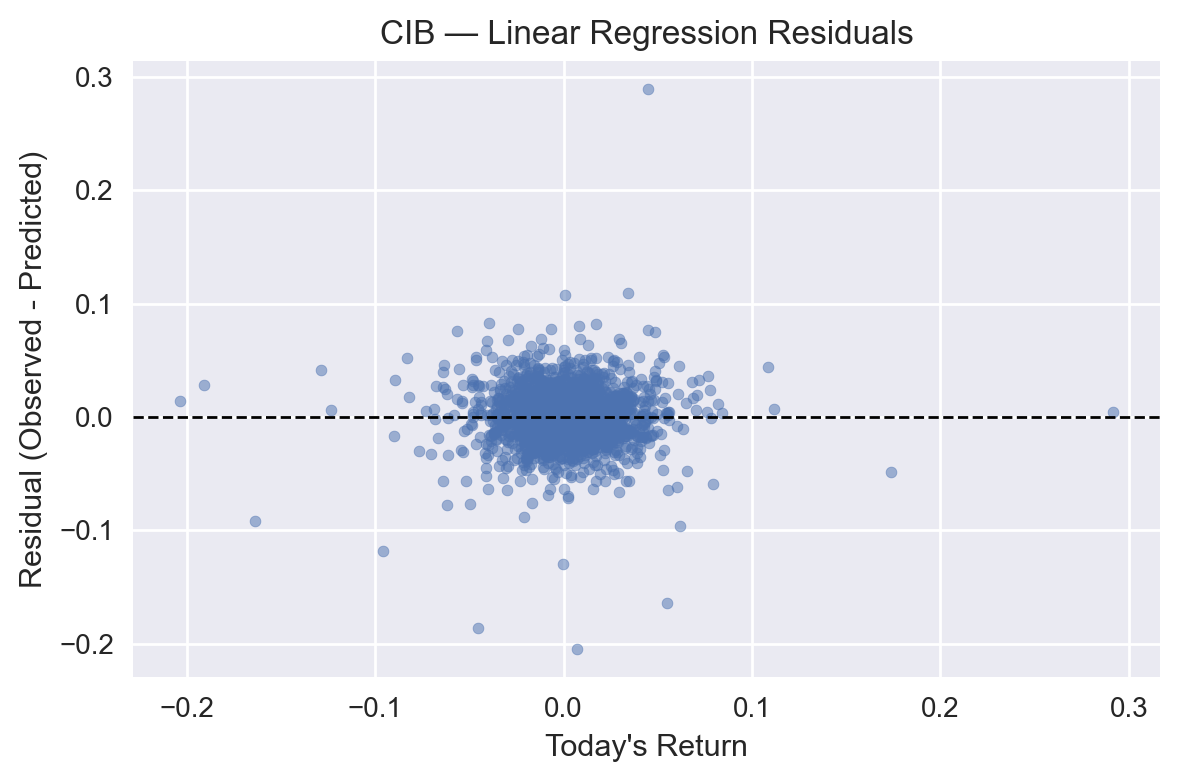

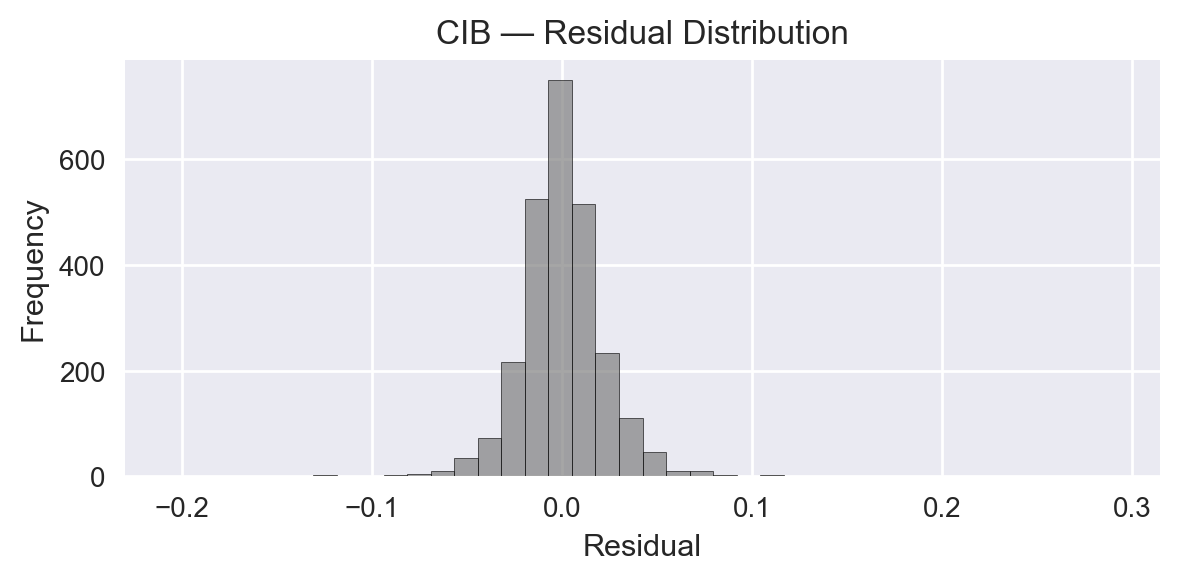

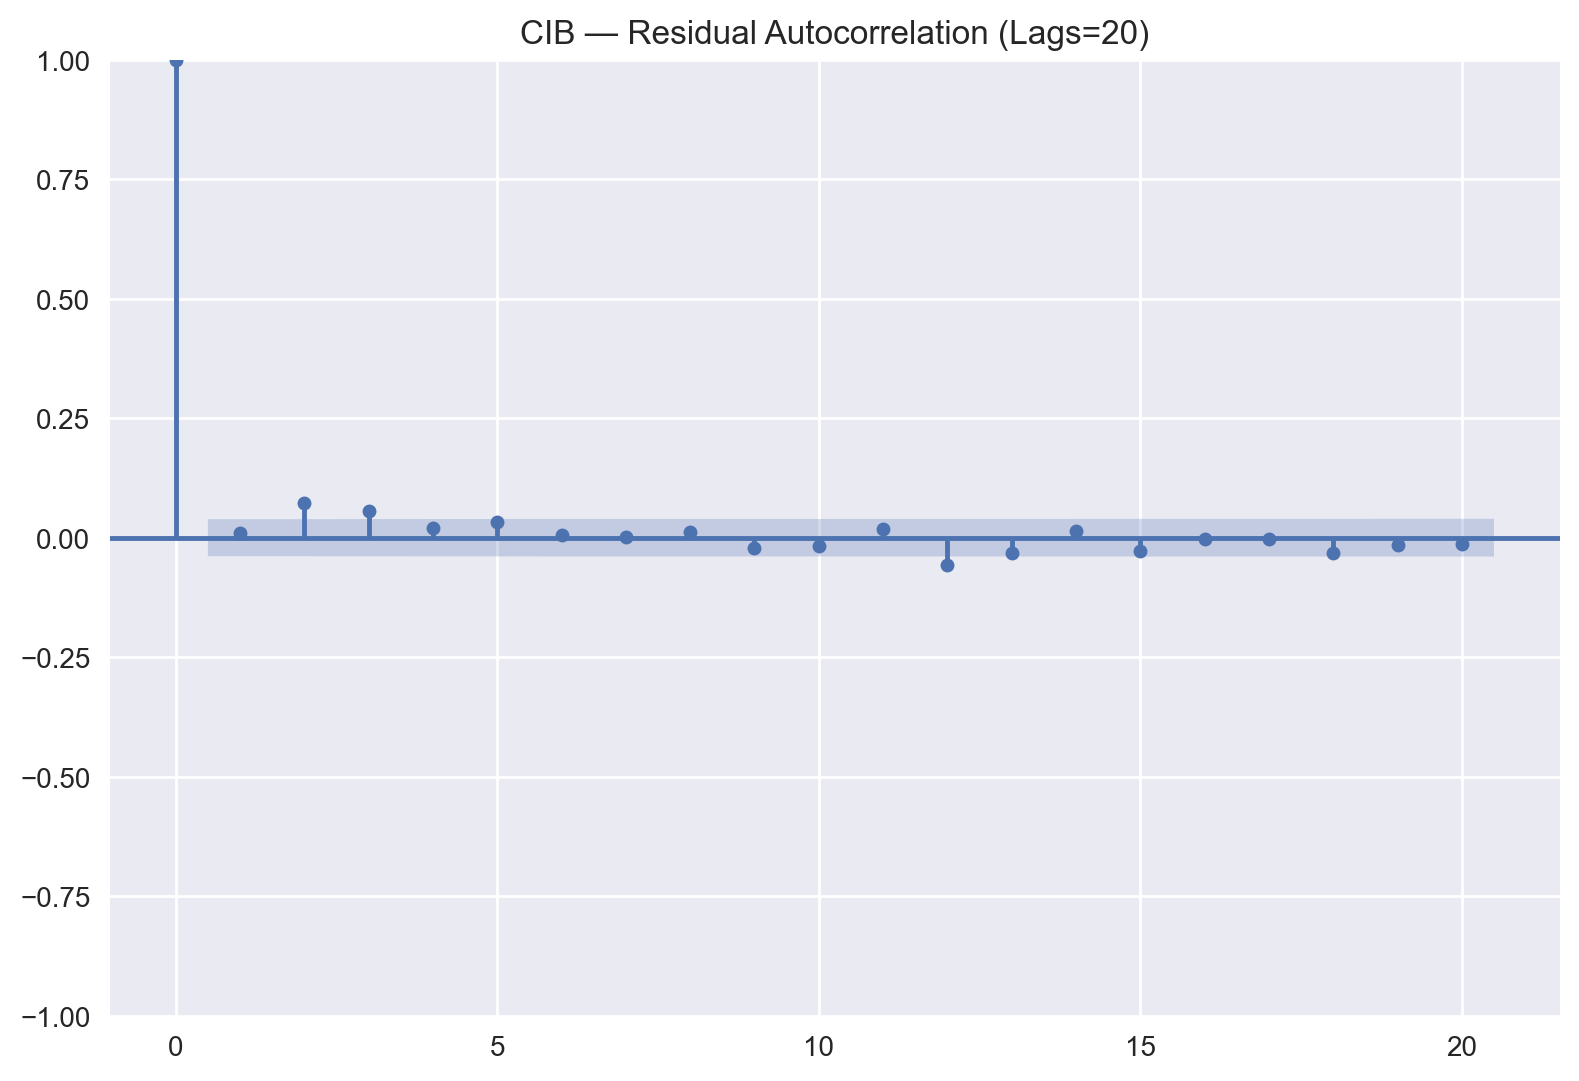

In [20]:
# ==============================================================
# 3.3 Residual Analysis — Checking Model Fit
# ==============================================================

# Residuals
residuals = yr - yr_pred

plt.figure(figsize=(6, 4))
plt.scatter(Xr, residuals, s=15, alpha=0.5)
plt.axhline(0, color="black", lw=1, linestyle="--")
plt.title(f"{ticker} — Linear Regression Residuals")
plt.xlabel("Today's Return")
plt.ylabel("Residual (Observed - Predicted)")
plt.tight_layout()
plt.show()

# --- Residual Distribution
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=40, color="gray", alpha=0.7, edgecolor="black")
plt.title(f"{ticker} — Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Optional: Autocorrelation of residuals
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title(f"{ticker} — Residual Autocorrelation (Lags=20)")
plt.tight_layout()
plt.show()

In [21]:
# ==============================================================
# 8. Model Comparison Summary — Classical ML on ADR Features
# ==============================================================

# Use clean binary target
X = df_t[["Return_1d", "VolChange"]].values
y = df_t["Target"].values

# Chronological split
split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Define models
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "SVM (RBF Kernel)": make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0, gamma="scale")),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# --- Fit and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))
    gap = acc_train - acc_test
    results.append({"Model": name, "Train Acc": acc_train, "Test Acc": acc_test, "Overfit Gap": gap})

# --- Summary table
summary_df = pd.DataFrame(results).sort_values("Test Acc", ascending=False).reset_index(drop=True)
summary_df.style.format({
    "Train Acc": "{:.3f}", "Test Acc": "{:.3f}", "Overfit Gap": "{:.3f}"
})


,Model,Train Acc,Test Acc,Overfit Gap
0,Decision Tree,0.559,0.499,0.060
1,SVM (RBF Kernel),0.546,0.490,0.056
2,Random Forest,0.647,0.487,0.161
3,Logistic Regression,0.524,0.471,0.053


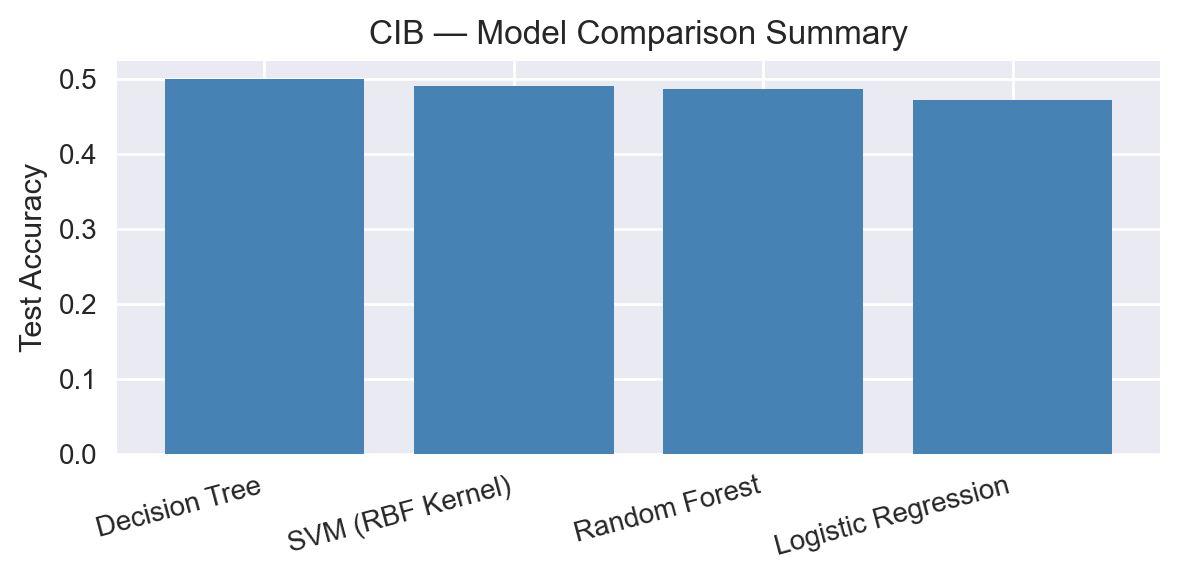

In [22]:
plt.figure(figsize=(6, 3))
plt.bar(summary_df["Model"], summary_df["Test Acc"], color="steelblue")
plt.xticks(rotation=15, ha="right")
plt.ylabel("Test Accuracy")
plt.title(f"{ticker} — Model Comparison Summary")
plt.tight_layout()
plt.show()